In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
#from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np


In [2]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()
        plt.close()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 

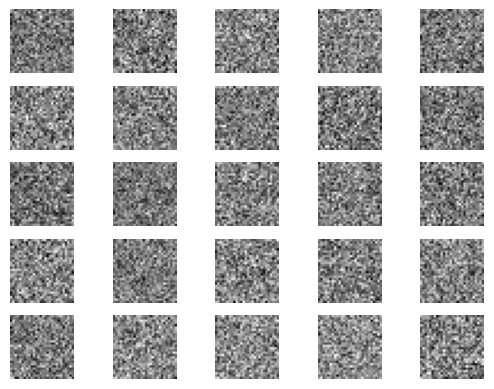

2/2 [==============================] - 0s 7ms/step
1 [D loss: 0.313212, acc.: 100.00%] [G loss: 0.944458]
2/2 [==============================] - 0s 7ms/step
2 [D loss: 0.284560, acc.: 98.44%] [G loss: 1.028813]
2/2 [==============================] - 0s 10ms/step
3 [D loss: 0.266831, acc.: 100.00%] [G loss: 1.082831]
2/2 [==============================] - 0s 11ms/step
4 [D loss: 0.238200, acc.: 100.00%] [G loss: 1.241435]
2/2 [==============================] - 0s 10ms/step
5 [D loss: 0.204009, acc.: 100.00%] [G loss: 1.317362]
2/2 [==============================] - 0s 7ms/step
6 [D loss: 0.165093, acc.: 100.00%] [G loss: 1.567469]
2/2 [==============================] - 0s 8ms/step
7 [D loss: 0.150008, acc.: 100.00%] [G loss: 1.677081]
2/2 [==============================] - 0s 5ms/step
8 [D loss: 0.117703, acc.: 100.00%] [G loss: 1.878144]
2/2 [==============================] - 0s 8ms/step
9 [D loss: 0.101831, acc.: 100.00%] [G loss: 2.130203]
2/2 [==============================] - 0s 4m

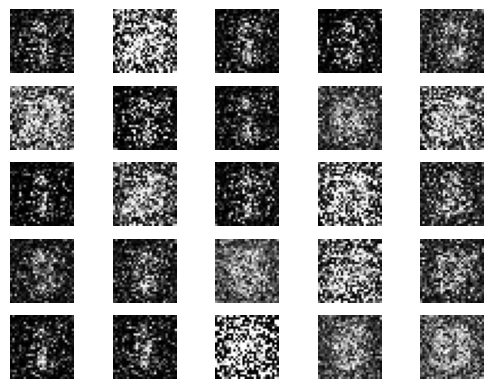

2/2 [==============================] - 0s 8ms/step
201 [D loss: 0.383734, acc.: 79.69%] [G loss: 2.916713]
2/2 [==============================] - 0s 15ms/step
202 [D loss: 0.262994, acc.: 88.28%] [G loss: 3.243426]
2/2 [==============================] - 0s 10ms/step
203 [D loss: 0.669252, acc.: 66.41%] [G loss: 1.663417]
2/2 [==============================] - 0s 8ms/step
204 [D loss: 0.241641, acc.: 92.19%] [G loss: 2.837258]
2/2 [==============================] - 0s 7ms/step
205 [D loss: 0.528067, acc.: 74.22%] [G loss: 1.793775]
2/2 [==============================] - 0s 8ms/step
206 [D loss: 0.314911, acc.: 87.50%] [G loss: 2.454190]
2/2 [==============================] - 0s 4ms/step
207 [D loss: 0.381498, acc.: 84.38%] [G loss: 2.996099]
2/2 [==============================] - 0s 4ms/step
208 [D loss: 0.452963, acc.: 82.03%] [G loss: 2.550161]
2/2 [==============================] - 0s 4ms/step
209 [D loss: 0.522223, acc.: 69.53%] [G loss: 1.992100]
2/2 [==============================

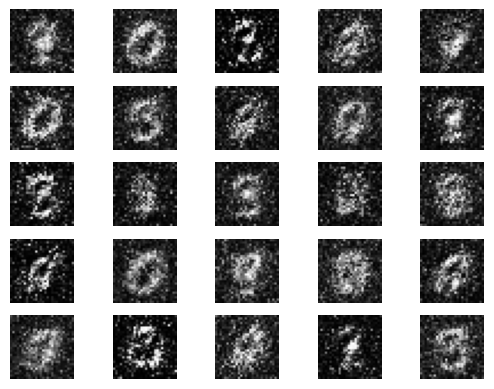

2/2 [==============================] - 0s 9ms/step
401 [D loss: 0.675057, acc.: 46.88%] [G loss: 0.684299]
2/2 [==============================] - 0s 6ms/step
402 [D loss: 0.640762, acc.: 50.00%] [G loss: 0.674086]
2/2 [==============================] - 0s 8ms/step
403 [D loss: 0.645709, acc.: 50.00%] [G loss: 0.686709]
2/2 [==============================] - 0s 6ms/step
404 [D loss: 0.654987, acc.: 47.66%] [G loss: 0.684478]
2/2 [==============================] - 0s 10ms/step
405 [D loss: 0.658929, acc.: 46.09%] [G loss: 0.673787]
2/2 [==============================] - 0s 12ms/step
406 [D loss: 0.652801, acc.: 48.44%] [G loss: 0.672127]
2/2 [==============================] - 0s 4ms/step
407 [D loss: 0.662806, acc.: 49.22%] [G loss: 0.674521]
2/2 [==============================] - 0s 6ms/step
408 [D loss: 0.657971, acc.: 53.91%] [G loss: 0.672437]
2/2 [==============================] - 0s 11ms/step
409 [D loss: 0.658661, acc.: 49.22%] [G loss: 0.670860]
2/2 [=============================

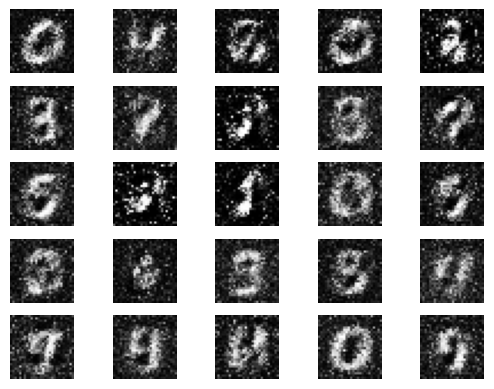

2/2 [==============================] - 0s 7ms/step
601 [D loss: 0.653178, acc.: 60.94%] [G loss: 0.723526]
2/2 [==============================] - 0s 8ms/step
602 [D loss: 0.653393, acc.: 60.16%] [G loss: 0.725533]
2/2 [==============================] - 0s 9ms/step
603 [D loss: 0.631195, acc.: 64.84%] [G loss: 0.748121]
2/2 [==============================] - 0s 10ms/step
604 [D loss: 0.661351, acc.: 60.94%] [G loss: 0.734414]
2/2 [==============================] - 0s 4ms/step
605 [D loss: 0.642840, acc.: 64.06%] [G loss: 0.730887]
2/2 [==============================] - 0s 5ms/step
606 [D loss: 0.660439, acc.: 57.81%] [G loss: 0.733601]
2/2 [==============================] - 0s 11ms/step
607 [D loss: 0.664944, acc.: 59.38%] [G loss: 0.747576]
2/2 [==============================] - 0s 4ms/step
608 [D loss: 0.639227, acc.: 67.19%] [G loss: 0.750899]
2/2 [==============================] - 0s 7ms/step
609 [D loss: 0.625909, acc.: 67.19%] [G loss: 0.756970]
2/2 [==============================

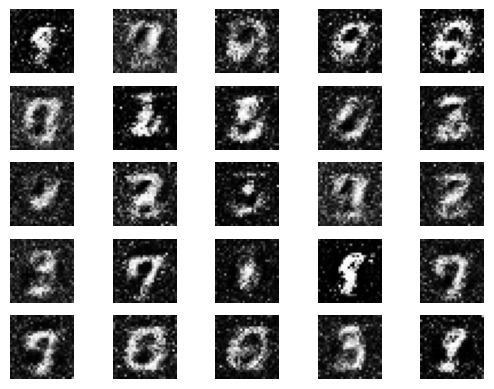

2/2 [==============================] - 0s 8ms/step
801 [D loss: 0.626090, acc.: 66.41%] [G loss: 0.788719]
2/2 [==============================] - 0s 14ms/step
802 [D loss: 0.641036, acc.: 64.84%] [G loss: 0.790895]
2/2 [==============================] - 0s 5ms/step
803 [D loss: 0.617012, acc.: 70.31%] [G loss: 0.818917]
2/2 [==============================] - 0s 5ms/step
804 [D loss: 0.622873, acc.: 71.88%] [G loss: 0.798710]
2/2 [==============================] - 0s 12ms/step
805 [D loss: 0.628421, acc.: 65.62%] [G loss: 0.777575]
2/2 [==============================] - 0s 4ms/step
806 [D loss: 0.616383, acc.: 75.00%] [G loss: 0.781105]
2/2 [==============================] - 0s 9ms/step
807 [D loss: 0.636004, acc.: 58.59%] [G loss: 0.761701]
2/2 [==============================] - 0s 7ms/step
808 [D loss: 0.607674, acc.: 64.06%] [G loss: 0.767391]
2/2 [==============================] - 0s 13ms/step
809 [D loss: 0.622291, acc.: 68.75%] [G loss: 0.770203]
2/2 [=============================

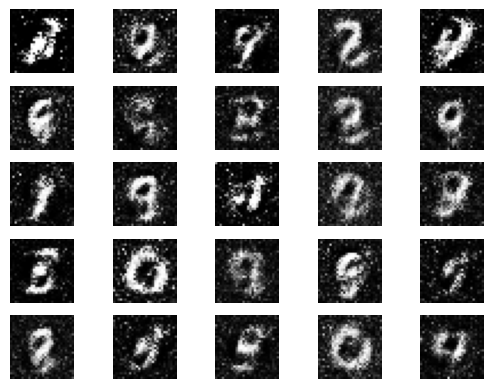

2/2 [==============================] - 0s 4ms/step
1001 [D loss: 0.575325, acc.: 75.78%] [G loss: 0.891512]
2/2 [==============================] - 0s 10ms/step
1002 [D loss: 0.613788, acc.: 66.41%] [G loss: 0.858881]
2/2 [==============================] - 0s 5ms/step
1003 [D loss: 0.635158, acc.: 64.84%] [G loss: 0.828533]
2/2 [==============================] - 0s 14ms/step
1004 [D loss: 0.626949, acc.: 60.16%] [G loss: 0.850302]
2/2 [==============================] - 0s 6ms/step
1005 [D loss: 0.625033, acc.: 65.62%] [G loss: 0.843480]
2/2 [==============================] - 0s 9ms/step
1006 [D loss: 0.610382, acc.: 68.75%] [G loss: 0.844041]
2/2 [==============================] - 0s 7ms/step
1007 [D loss: 0.601527, acc.: 67.19%] [G loss: 0.887592]
2/2 [==============================] - 0s 13ms/step
1008 [D loss: 0.597818, acc.: 76.56%] [G loss: 0.880994]
2/2 [==============================] - 0s 5ms/step
1009 [D loss: 0.602257, acc.: 73.44%] [G loss: 0.868821]
2/2 [====================

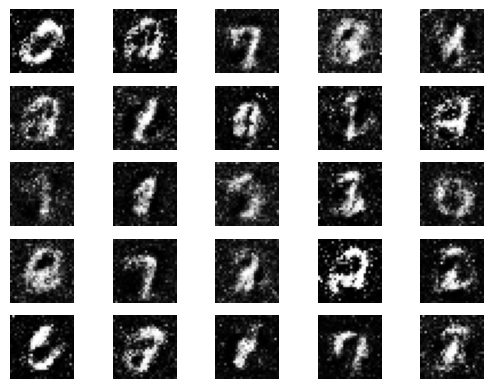

2/2 [==============================] - 0s 6ms/step
1201 [D loss: 0.538163, acc.: 85.16%] [G loss: 0.904901]
2/2 [==============================] - 0s 10ms/step
1202 [D loss: 0.574357, acc.: 74.22%] [G loss: 0.913614]
2/2 [==============================] - 0s 7ms/step
1203 [D loss: 0.570306, acc.: 74.22%] [G loss: 0.915132]
2/2 [==============================] - 0s 7ms/step
1204 [D loss: 0.604754, acc.: 74.22%] [G loss: 0.956889]
2/2 [==============================] - 0s 4ms/step
1205 [D loss: 0.561683, acc.: 76.56%] [G loss: 0.997818]
2/2 [==============================] - 0s 4ms/step
1206 [D loss: 0.576041, acc.: 75.78%] [G loss: 0.961256]
2/2 [==============================] - 0s 12ms/step
1207 [D loss: 0.546280, acc.: 82.81%] [G loss: 1.005795]
2/2 [==============================] - 0s 8ms/step
1208 [D loss: 0.595947, acc.: 73.44%] [G loss: 0.955632]
2/2 [==============================] - 0s 6ms/step
1209 [D loss: 0.542763, acc.: 82.81%] [G loss: 0.919710]
2/2 [=====================

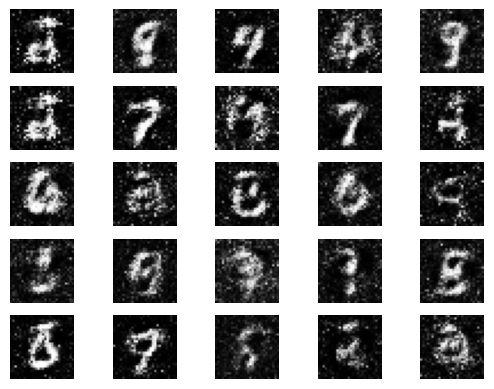

2/2 [==============================] - 0s 9ms/step
1401 [D loss: 0.572135, acc.: 73.44%] [G loss: 0.923463]
2/2 [==============================] - 0s 11ms/step
1402 [D loss: 0.581429, acc.: 71.09%] [G loss: 0.958332]
2/2 [==============================] - 0s 9ms/step
1403 [D loss: 0.567032, acc.: 77.34%] [G loss: 0.940743]
2/2 [==============================] - 0s 7ms/step
1404 [D loss: 0.616870, acc.: 64.84%] [G loss: 0.921535]
2/2 [==============================] - 0s 5ms/step
1405 [D loss: 0.560318, acc.: 81.25%] [G loss: 0.970015]
2/2 [==============================] - 0s 16ms/step
1406 [D loss: 0.554978, acc.: 78.12%] [G loss: 0.941940]
2/2 [==============================] - 0s 4ms/step
1407 [D loss: 0.615476, acc.: 67.19%] [G loss: 0.918186]
2/2 [==============================] - 0s 10ms/step
1408 [D loss: 0.601512, acc.: 67.19%] [G loss: 0.895390]
2/2 [==============================] - 0s 8ms/step
1409 [D loss: 0.595127, acc.: 70.31%] [G loss: 0.918745]
2/2 [====================

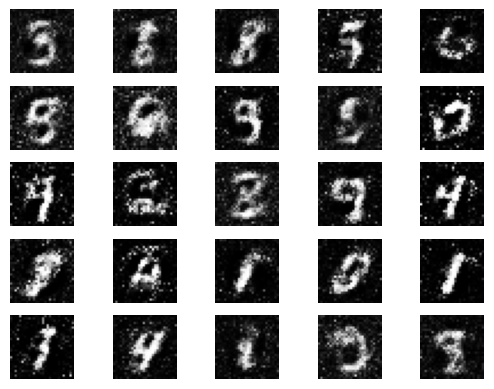

2/2 [==============================] - 0s 7ms/step
1601 [D loss: 0.559519, acc.: 73.44%] [G loss: 0.945039]
2/2 [==============================] - 0s 4ms/step
1602 [D loss: 0.586459, acc.: 71.09%] [G loss: 0.976931]
2/2 [==============================] - 0s 7ms/step
1603 [D loss: 0.594379, acc.: 73.44%] [G loss: 0.943812]
2/2 [==============================] - 0s 11ms/step
1604 [D loss: 0.635470, acc.: 64.84%] [G loss: 0.923229]
2/2 [==============================] - 0s 6ms/step
1605 [D loss: 0.604670, acc.: 67.97%] [G loss: 0.905769]
2/2 [==============================] - 0s 9ms/step
1606 [D loss: 0.597690, acc.: 68.75%] [G loss: 0.853146]
2/2 [==============================] - 0s 10ms/step
1607 [D loss: 0.557479, acc.: 73.44%] [G loss: 0.976154]
2/2 [==============================] - 0s 7ms/step
1608 [D loss: 0.534671, acc.: 80.47%] [G loss: 0.941008]
2/2 [==============================] - 0s 5ms/step
1609 [D loss: 0.593493, acc.: 69.53%] [G loss: 0.951833]
2/2 [=====================

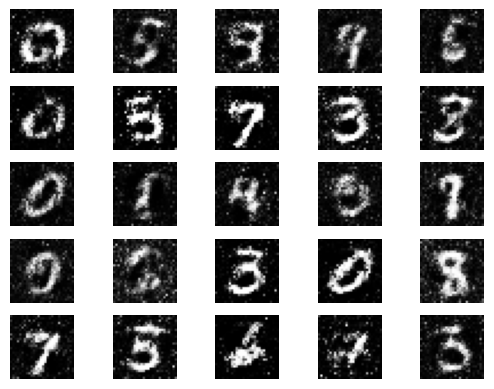

2/2 [==============================] - 0s 4ms/step
1801 [D loss: 0.588004, acc.: 73.44%] [G loss: 0.948465]
2/2 [==============================] - 0s 16ms/step
1802 [D loss: 0.599478, acc.: 67.19%] [G loss: 0.955963]
2/2 [==============================] - 0s 10ms/step
1803 [D loss: 0.575082, acc.: 78.91%] [G loss: 1.006926]
2/2 [==============================] - 0s 5ms/step
1804 [D loss: 0.577245, acc.: 71.88%] [G loss: 0.972087]
2/2 [==============================] - 0s 7ms/step
1805 [D loss: 0.584098, acc.: 72.66%] [G loss: 0.944602]
2/2 [==============================] - 0s 14ms/step
1806 [D loss: 0.627210, acc.: 66.41%] [G loss: 0.906638]
2/2 [==============================] - 0s 4ms/step
1807 [D loss: 0.575826, acc.: 74.22%] [G loss: 0.929682]
2/2 [==============================] - 0s 11ms/step
1808 [D loss: 0.651196, acc.: 63.28%] [G loss: 0.923333]
2/2 [==============================] - 0s 5ms/step
1809 [D loss: 0.574213, acc.: 75.00%] [G loss: 0.933934]
2/2 [===================

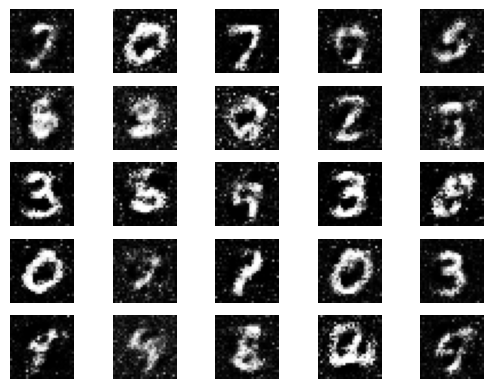

2/2 [==============================] - 0s 4ms/step
2001 [D loss: 0.612648, acc.: 64.84%] [G loss: 0.893389]
2/2 [==============================] - 0s 9ms/step
2002 [D loss: 0.598003, acc.: 71.09%] [G loss: 0.950150]
2/2 [==============================] - 0s 4ms/step
2003 [D loss: 0.594548, acc.: 69.53%] [G loss: 0.936149]
2/2 [==============================] - 0s 4ms/step
2004 [D loss: 0.610596, acc.: 67.97%] [G loss: 0.900594]
2/2 [==============================] - 0s 5ms/step
2005 [D loss: 0.610089, acc.: 69.53%] [G loss: 0.953340]
2/2 [==============================] - 0s 6ms/step
2006 [D loss: 0.595650, acc.: 71.88%] [G loss: 0.938673]
2/2 [==============================] - 0s 7ms/step
2007 [D loss: 0.586958, acc.: 73.44%] [G loss: 0.972754]
2/2 [==============================] - 0s 4ms/step
2008 [D loss: 0.620969, acc.: 64.06%] [G loss: 0.952079]
2/2 [==============================] - 0s 6ms/step
2009 [D loss: 0.601719, acc.: 70.31%] [G loss: 0.926959]
2/2 [=======================

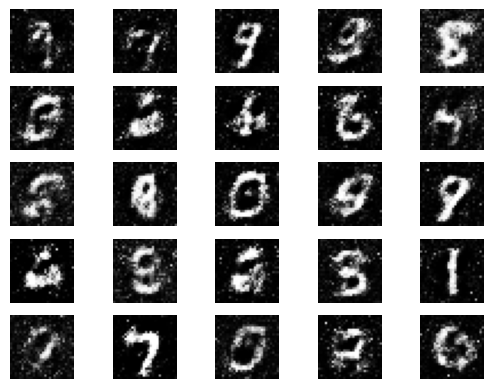

2/2 [==============================] - 0s 8ms/step
2201 [D loss: 0.600343, acc.: 70.31%] [G loss: 0.962121]
2/2 [==============================] - 0s 10ms/step
2202 [D loss: 0.581979, acc.: 73.44%] [G loss: 0.940169]
2/2 [==============================] - 0s 11ms/step
2203 [D loss: 0.576360, acc.: 76.56%] [G loss: 0.967904]
2/2 [==============================] - 0s 4ms/step
2204 [D loss: 0.580543, acc.: 71.88%] [G loss: 0.976232]
2/2 [==============================] - 0s 5ms/step
2205 [D loss: 0.617611, acc.: 70.31%] [G loss: 0.952104]
2/2 [==============================] - 0s 4ms/step
2206 [D loss: 0.587128, acc.: 69.53%] [G loss: 0.958954]
2/2 [==============================] - 0s 9ms/step
2207 [D loss: 0.604262, acc.: 70.31%] [G loss: 0.941424]
2/2 [==============================] - 0s 11ms/step
2208 [D loss: 0.611508, acc.: 65.62%] [G loss: 0.898247]
2/2 [==============================] - 0s 8ms/step
2209 [D loss: 0.581321, acc.: 71.88%] [G loss: 0.935769]
2/2 [====================

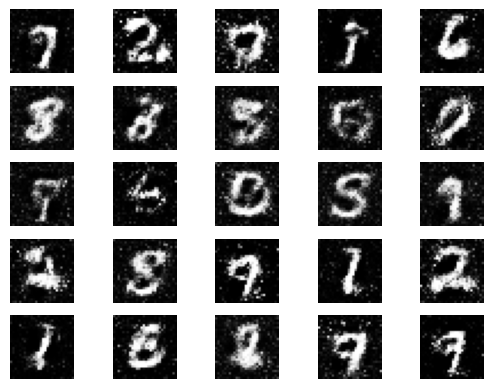

2/2 [==============================] - 0s 4ms/step
2401 [D loss: 0.613847, acc.: 66.41%] [G loss: 0.984789]
2/2 [==============================] - 0s 6ms/step
2402 [D loss: 0.592852, acc.: 68.75%] [G loss: 0.944171]
2/2 [==============================] - 0s 7ms/step
2403 [D loss: 0.580228, acc.: 74.22%] [G loss: 0.918370]
2/2 [==============================] - 0s 5ms/step
2404 [D loss: 0.567824, acc.: 67.97%] [G loss: 1.025677]
2/2 [==============================] - 0s 4ms/step
2405 [D loss: 0.561325, acc.: 71.88%] [G loss: 1.048579]
2/2 [==============================] - 0s 6ms/step
2406 [D loss: 0.623541, acc.: 64.84%] [G loss: 0.990589]
2/2 [==============================] - 0s 4ms/step
2407 [D loss: 0.579469, acc.: 71.88%] [G loss: 0.915910]
2/2 [==============================] - 0s 7ms/step
2408 [D loss: 0.584786, acc.: 72.66%] [G loss: 0.931966]
2/2 [==============================] - 0s 16ms/step
2409 [D loss: 0.584998, acc.: 71.09%] [G loss: 0.916117]
2/2 [======================

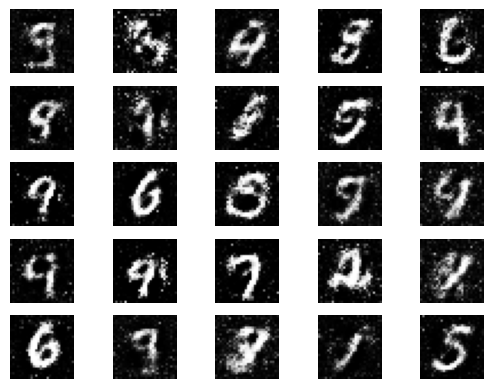

2/2 [==============================] - 0s 3ms/step
2601 [D loss: 0.577291, acc.: 72.66%] [G loss: 0.923298]
2/2 [==============================] - 0s 6ms/step
2602 [D loss: 0.640204, acc.: 64.06%] [G loss: 0.904620]
2/2 [==============================] - 0s 4ms/step
2603 [D loss: 0.605300, acc.: 62.50%] [G loss: 0.970977]
2/2 [==============================] - 0s 5ms/step
2604 [D loss: 0.567633, acc.: 75.00%] [G loss: 0.976316]
2/2 [==============================] - 0s 5ms/step
2605 [D loss: 0.611985, acc.: 67.19%] [G loss: 0.949955]
2/2 [==============================] - 0s 6ms/step
2606 [D loss: 0.605583, acc.: 67.19%] [G loss: 0.867795]
2/2 [==============================] - 0s 11ms/step
2607 [D loss: 0.567739, acc.: 74.22%] [G loss: 0.984817]
2/2 [==============================] - 0s 8ms/step
2608 [D loss: 0.610273, acc.: 66.41%] [G loss: 0.975422]
2/2 [==============================] - 0s 7ms/step
2609 [D loss: 0.599541, acc.: 67.97%] [G loss: 0.920394]
2/2 [======================

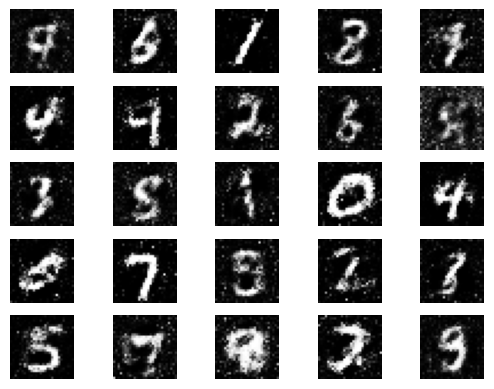

2/2 [==============================] - 0s 5ms/step
2801 [D loss: 0.560461, acc.: 78.91%] [G loss: 0.956620]
2/2 [==============================] - 0s 7ms/step
2802 [D loss: 0.583888, acc.: 73.44%] [G loss: 0.917259]
2/2 [==============================] - 0s 8ms/step
2803 [D loss: 0.602531, acc.: 65.62%] [G loss: 0.976452]
2/2 [==============================] - 0s 5ms/step
2804 [D loss: 0.584368, acc.: 75.00%] [G loss: 1.004228]
2/2 [==============================] - 0s 8ms/step
2805 [D loss: 0.645044, acc.: 60.16%] [G loss: 0.960114]
2/2 [==============================] - 0s 5ms/step
2806 [D loss: 0.597003, acc.: 67.97%] [G loss: 0.944150]
2/2 [==============================] - 0s 5ms/step
2807 [D loss: 0.599861, acc.: 68.75%] [G loss: 0.921298]
2/2 [==============================] - 0s 4ms/step
2808 [D loss: 0.617430, acc.: 66.41%] [G loss: 0.956875]
2/2 [==============================] - 0s 6ms/step
2809 [D loss: 0.581939, acc.: 75.78%] [G loss: 0.948030]
2/2 [=======================

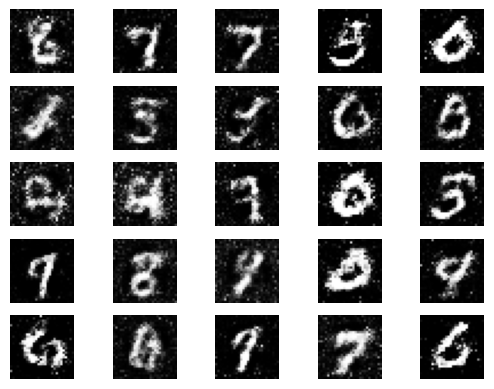

2/2 [==============================] - 0s 7ms/step
3001 [D loss: 0.658319, acc.: 58.59%] [G loss: 0.930099]
2/2 [==============================] - 0s 4ms/step
3002 [D loss: 0.593639, acc.: 71.88%] [G loss: 0.975949]
2/2 [==============================] - 0s 5ms/step
3003 [D loss: 0.603245, acc.: 70.31%] [G loss: 0.977500]
2/2 [==============================] - 0s 4ms/step
3004 [D loss: 0.617367, acc.: 67.19%] [G loss: 0.934693]
2/2 [==============================] - 0s 4ms/step
3005 [D loss: 0.581518, acc.: 71.09%] [G loss: 0.949855]
2/2 [==============================] - 0s 5ms/step
3006 [D loss: 0.646145, acc.: 62.50%] [G loss: 0.881928]
2/2 [==============================] - 0s 4ms/step
3007 [D loss: 0.626517, acc.: 64.06%] [G loss: 0.934828]
2/2 [==============================] - 0s 4ms/step
3008 [D loss: 0.598255, acc.: 71.09%] [G loss: 0.911009]
2/2 [==============================] - 0s 4ms/step
3009 [D loss: 0.629901, acc.: 64.06%] [G loss: 0.939194]
2/2 [=======================

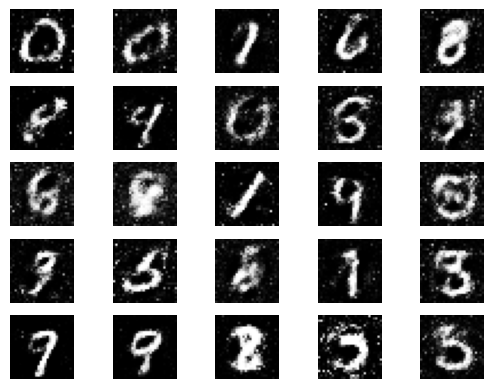

2/2 [==============================] - 0s 4ms/step
3201 [D loss: 0.583320, acc.: 70.31%] [G loss: 0.991680]
2/2 [==============================] - 0s 4ms/step
3202 [D loss: 0.589259, acc.: 71.09%] [G loss: 0.977437]
2/2 [==============================] - 0s 9ms/step
3203 [D loss: 0.616117, acc.: 71.88%] [G loss: 0.962696]
2/2 [==============================] - 0s 5ms/step
3204 [D loss: 0.609617, acc.: 66.41%] [G loss: 0.917490]
2/2 [==============================] - 0s 4ms/step
3205 [D loss: 0.639674, acc.: 65.62%] [G loss: 0.859622]
2/2 [==============================] - 0s 4ms/step
3206 [D loss: 0.604926, acc.: 70.31%] [G loss: 0.942481]
2/2 [==============================] - 0s 4ms/step
3207 [D loss: 0.666995, acc.: 57.03%] [G loss: 0.951511]
2/2 [==============================] - 0s 5ms/step
3208 [D loss: 0.597847, acc.: 71.09%] [G loss: 0.978123]
2/2 [==============================] - 0s 7ms/step
3209 [D loss: 0.612621, acc.: 70.31%] [G loss: 0.905279]
2/2 [=======================

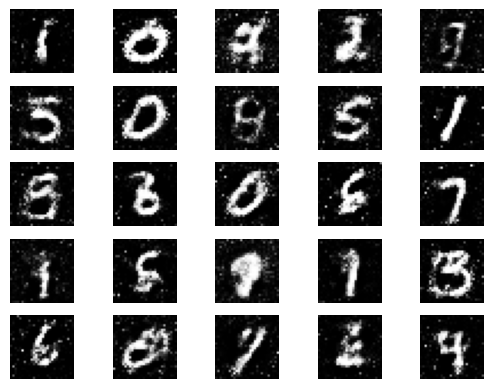

2/2 [==============================] - 0s 7ms/step
3401 [D loss: 0.643960, acc.: 64.84%] [G loss: 0.903742]
2/2 [==============================] - 0s 4ms/step
3402 [D loss: 0.588044, acc.: 69.53%] [G loss: 0.930476]
2/2 [==============================] - 0s 4ms/step
3403 [D loss: 0.602537, acc.: 67.19%] [G loss: 0.907274]
2/2 [==============================] - 0s 4ms/step
3404 [D loss: 0.596657, acc.: 71.88%] [G loss: 0.961825]
2/2 [==============================] - 0s 8ms/step
3405 [D loss: 0.616230, acc.: 62.50%] [G loss: 0.945259]
2/2 [==============================] - 0s 6ms/step
3406 [D loss: 0.602852, acc.: 66.41%] [G loss: 0.931545]
2/2 [==============================] - 0s 4ms/step
3407 [D loss: 0.620365, acc.: 67.97%] [G loss: 1.012019]
2/2 [==============================] - 0s 15ms/step
3408 [D loss: 0.601485, acc.: 71.88%] [G loss: 0.979927]
2/2 [==============================] - 0s 4ms/step
3409 [D loss: 0.657355, acc.: 58.59%] [G loss: 0.887571]
2/2 [======================

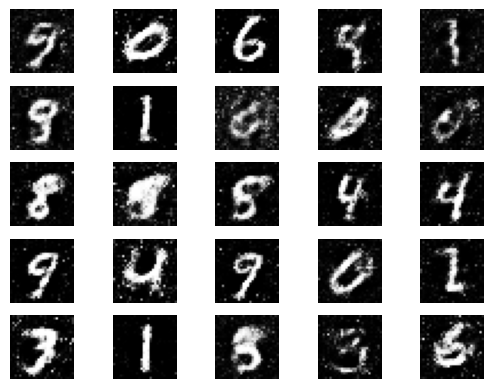

2/2 [==============================] - 0s 4ms/step
3601 [D loss: 0.644776, acc.: 61.72%] [G loss: 0.943764]
2/2 [==============================] - 0s 4ms/step
3602 [D loss: 0.622897, acc.: 64.84%] [G loss: 0.925818]
2/2 [==============================] - 0s 6ms/step
3603 [D loss: 0.621887, acc.: 71.09%] [G loss: 0.953683]
2/2 [==============================] - 0s 4ms/step
3604 [D loss: 0.614542, acc.: 67.97%] [G loss: 0.924673]
2/2 [==============================] - 0s 11ms/step
3605 [D loss: 0.588170, acc.: 70.31%] [G loss: 0.885921]
2/2 [==============================] - 0s 6ms/step
3606 [D loss: 0.617120, acc.: 68.75%] [G loss: 0.963977]
2/2 [==============================] - 0s 5ms/step
3607 [D loss: 0.650074, acc.: 64.84%] [G loss: 0.988849]
2/2 [==============================] - 0s 8ms/step
3608 [D loss: 0.599356, acc.: 71.09%] [G loss: 0.929424]
2/2 [==============================] - 0s 4ms/step
3609 [D loss: 0.679853, acc.: 57.03%] [G loss: 0.916975]
2/2 [======================

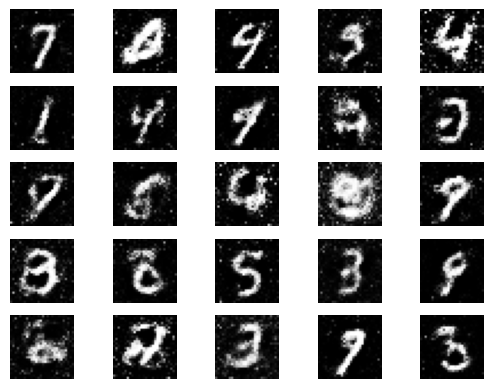

2/2 [==============================] - 0s 8ms/step
3801 [D loss: 0.630180, acc.: 60.94%] [G loss: 0.939375]
2/2 [==============================] - 0s 4ms/step
3802 [D loss: 0.607107, acc.: 64.84%] [G loss: 0.949890]
2/2 [==============================] - 0s 8ms/step
3803 [D loss: 0.605768, acc.: 68.75%] [G loss: 0.917444]
2/2 [==============================] - 0s 8ms/step
3804 [D loss: 0.678983, acc.: 59.38%] [G loss: 0.966284]
2/2 [==============================] - 0s 5ms/step
3805 [D loss: 0.595294, acc.: 66.41%] [G loss: 0.940095]
2/2 [==============================] - 0s 5ms/step
3806 [D loss: 0.664054, acc.: 59.38%] [G loss: 0.873848]
2/2 [==============================] - 0s 7ms/step
3807 [D loss: 0.594464, acc.: 75.00%] [G loss: 0.901233]
2/2 [==============================] - 0s 4ms/step
3808 [D loss: 0.618531, acc.: 67.97%] [G loss: 0.898752]
2/2 [==============================] - 0s 5ms/step
3809 [D loss: 0.649526, acc.: 64.84%] [G loss: 0.819535]
2/2 [=======================

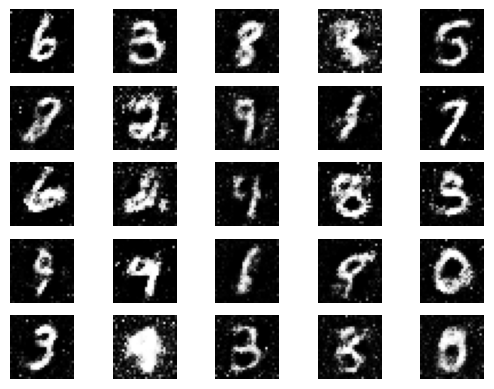

2/2 [==============================] - 0s 5ms/step
4001 [D loss: 0.622220, acc.: 65.62%] [G loss: 0.913157]
2/2 [==============================] - 0s 7ms/step
4002 [D loss: 0.639332, acc.: 60.94%] [G loss: 0.909215]
2/2 [==============================] - 0s 6ms/step
4003 [D loss: 0.648884, acc.: 60.94%] [G loss: 0.874949]
2/2 [==============================] - 0s 6ms/step
4004 [D loss: 0.605923, acc.: 68.75%] [G loss: 0.913531]
2/2 [==============================] - 0s 4ms/step
4005 [D loss: 0.641973, acc.: 60.94%] [G loss: 0.925650]
2/2 [==============================] - 0s 5ms/step
4006 [D loss: 0.637671, acc.: 61.72%] [G loss: 0.919042]
2/2 [==============================] - 0s 4ms/step
4007 [D loss: 0.649465, acc.: 63.28%] [G loss: 0.893963]
2/2 [==============================] - 0s 4ms/step
4008 [D loss: 0.600358, acc.: 70.31%] [G loss: 0.927272]
2/2 [==============================] - 0s 5ms/step
4009 [D loss: 0.571123, acc.: 70.31%] [G loss: 0.951955]
2/2 [=======================

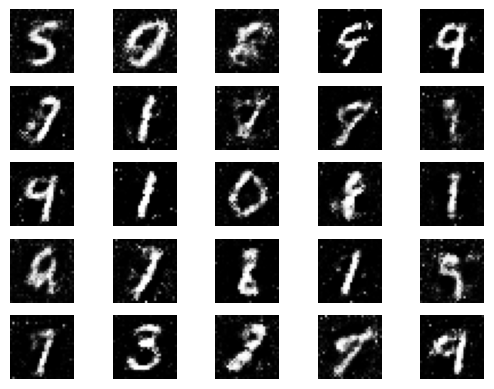

2/2 [==============================] - 0s 5ms/step
4201 [D loss: 0.643154, acc.: 59.38%] [G loss: 0.902642]
2/2 [==============================] - 0s 7ms/step
4202 [D loss: 0.640383, acc.: 63.28%] [G loss: 0.933640]
2/2 [==============================] - 0s 9ms/step
4203 [D loss: 0.634919, acc.: 63.28%] [G loss: 0.899038]
2/2 [==============================] - 0s 5ms/step
4204 [D loss: 0.630445, acc.: 65.62%] [G loss: 0.929242]
2/2 [==============================] - 0s 8ms/step
4205 [D loss: 0.660762, acc.: 64.84%] [G loss: 0.885141]
2/2 [==============================] - 0s 7ms/step
4206 [D loss: 0.671766, acc.: 64.06%] [G loss: 0.880195]
2/2 [==============================] - 0s 9ms/step
4207 [D loss: 0.619805, acc.: 66.41%] [G loss: 0.958374]
2/2 [==============================] - 0s 12ms/step
4208 [D loss: 0.593697, acc.: 68.75%] [G loss: 0.938960]
2/2 [==============================] - 0s 4ms/step
4209 [D loss: 0.618361, acc.: 69.53%] [G loss: 0.890682]
2/2 [======================

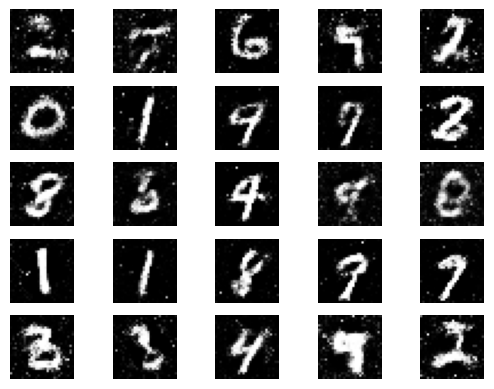

2/2 [==============================] - 0s 4ms/step
4401 [D loss: 0.657930, acc.: 60.94%] [G loss: 0.915976]
2/2 [==============================] - 0s 4ms/step
4402 [D loss: 0.652950, acc.: 60.94%] [G loss: 0.898077]
2/2 [==============================] - 0s 6ms/step
4403 [D loss: 0.648560, acc.: 64.84%] [G loss: 0.928807]
2/2 [==============================] - 0s 8ms/step
4404 [D loss: 0.648924, acc.: 60.94%] [G loss: 0.899432]
2/2 [==============================] - 0s 4ms/step
4405 [D loss: 0.634348, acc.: 60.16%] [G loss: 0.930546]
2/2 [==============================] - 0s 4ms/step
4406 [D loss: 0.620822, acc.: 68.75%] [G loss: 0.914749]
2/2 [==============================] - 0s 4ms/step
4407 [D loss: 0.642615, acc.: 60.94%] [G loss: 0.922824]
2/2 [==============================] - 0s 8ms/step
4408 [D loss: 0.671734, acc.: 57.03%] [G loss: 0.955840]
2/2 [==============================] - 0s 6ms/step
4409 [D loss: 0.656217, acc.: 60.16%] [G loss: 0.885561]
2/2 [=======================

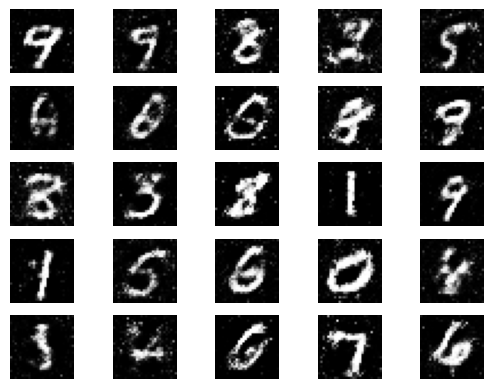

2/2 [==============================] - 0s 6ms/step
4601 [D loss: 0.650393, acc.: 64.06%] [G loss: 0.948565]
2/2 [==============================] - 0s 6ms/step
4602 [D loss: 0.641184, acc.: 67.19%] [G loss: 0.904455]
2/2 [==============================] - 0s 4ms/step
4603 [D loss: 0.641404, acc.: 67.97%] [G loss: 0.939972]
2/2 [==============================] - 0s 5ms/step
4604 [D loss: 0.664907, acc.: 56.25%] [G loss: 0.931087]
2/2 [==============================] - 0s 4ms/step
4605 [D loss: 0.660589, acc.: 58.59%] [G loss: 0.888952]
2/2 [==============================] - 0s 7ms/step
4606 [D loss: 0.607470, acc.: 68.75%] [G loss: 0.911308]
2/2 [==============================] - 0s 4ms/step
4607 [D loss: 0.617608, acc.: 66.41%] [G loss: 0.908764]
2/2 [==============================] - 0s 4ms/step
4608 [D loss: 0.636545, acc.: 65.62%] [G loss: 0.878254]
2/2 [==============================] - 0s 4ms/step
4609 [D loss: 0.627847, acc.: 65.62%] [G loss: 0.895219]
2/2 [=======================

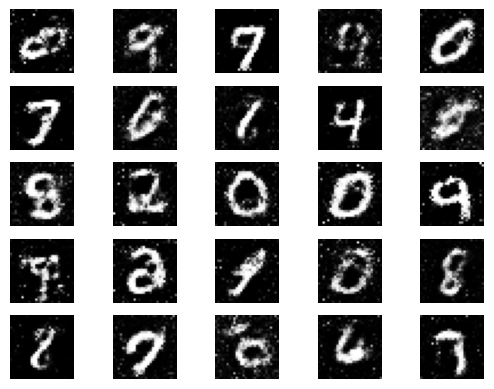

2/2 [==============================] - 0s 4ms/step
4801 [D loss: 0.638151, acc.: 66.41%] [G loss: 0.888113]
2/2 [==============================] - 0s 4ms/step
4802 [D loss: 0.649849, acc.: 61.72%] [G loss: 0.990774]
2/2 [==============================] - 0s 4ms/step
4803 [D loss: 0.649089, acc.: 60.16%] [G loss: 0.905971]
2/2 [==============================] - 0s 6ms/step
4804 [D loss: 0.647203, acc.: 63.28%] [G loss: 0.931189]
2/2 [==============================] - 0s 4ms/step
4805 [D loss: 0.627833, acc.: 64.84%] [G loss: 0.921192]
2/2 [==============================] - 0s 7ms/step
4806 [D loss: 0.714797, acc.: 54.69%] [G loss: 0.930909]
2/2 [==============================] - 0s 5ms/step
4807 [D loss: 0.622690, acc.: 66.41%] [G loss: 0.933759]
2/2 [==============================] - 0s 5ms/step
4808 [D loss: 0.623675, acc.: 62.50%] [G loss: 0.925366]
2/2 [==============================] - 0s 4ms/step
4809 [D loss: 0.645066, acc.: 64.84%] [G loss: 0.953753]
2/2 [=======================

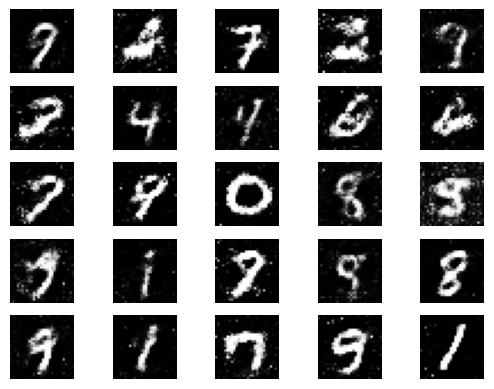

2/2 [==============================] - 0s 4ms/step
5001 [D loss: 0.651595, acc.: 61.72%] [G loss: 0.904132]
2/2 [==============================] - 0s 4ms/step
5002 [D loss: 0.656315, acc.: 65.62%] [G loss: 0.942715]
2/2 [==============================] - 0s 6ms/step
5003 [D loss: 0.674684, acc.: 57.03%] [G loss: 0.963364]
2/2 [==============================] - 0s 4ms/step
5004 [D loss: 0.606197, acc.: 73.44%] [G loss: 0.900963]
2/2 [==============================] - 0s 4ms/step
5005 [D loss: 0.657140, acc.: 64.06%] [G loss: 0.944828]
2/2 [==============================] - 0s 4ms/step
5006 [D loss: 0.640920, acc.: 62.50%] [G loss: 0.962428]
2/2 [==============================] - 0s 5ms/step
5007 [D loss: 0.627609, acc.: 67.19%] [G loss: 0.911197]
2/2 [==============================] - 0s 4ms/step
5008 [D loss: 0.678467, acc.: 55.47%] [G loss: 0.951771]
2/2 [==============================] - 0s 4ms/step
5009 [D loss: 0.677436, acc.: 60.16%] [G loss: 0.916953]
2/2 [=======================

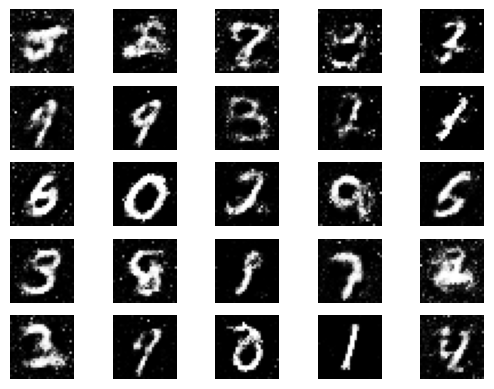

2/2 [==============================] - 0s 4ms/step
5201 [D loss: 0.624192, acc.: 63.28%] [G loss: 0.939773]
2/2 [==============================] - 0s 4ms/step
5202 [D loss: 0.616348, acc.: 72.66%] [G loss: 0.913486]
2/2 [==============================] - 0s 4ms/step
5203 [D loss: 0.621821, acc.: 65.62%] [G loss: 0.885159]
2/2 [==============================] - 0s 4ms/step
5204 [D loss: 0.647890, acc.: 59.38%] [G loss: 0.937129]
2/2 [==============================] - 0s 4ms/step
5205 [D loss: 0.661123, acc.: 57.03%] [G loss: 0.905696]
2/2 [==============================] - 0s 4ms/step
5206 [D loss: 0.647311, acc.: 59.38%] [G loss: 0.806278]
2/2 [==============================] - 0s 6ms/step
5207 [D loss: 0.649262, acc.: 64.84%] [G loss: 0.844062]
2/2 [==============================] - 0s 4ms/step
5208 [D loss: 0.615927, acc.: 72.66%] [G loss: 0.882882]
2/2 [==============================] - 0s 4ms/step
5209 [D loss: 0.627428, acc.: 65.62%] [G loss: 0.962843]
2/2 [=======================

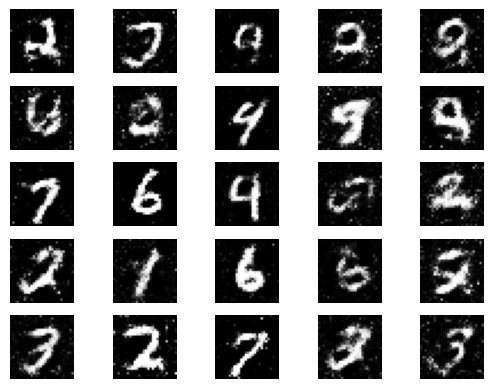

2/2 [==============================] - 0s 5ms/step
5401 [D loss: 0.676835, acc.: 57.03%] [G loss: 0.790598]
2/2 [==============================] - 0s 4ms/step
5402 [D loss: 0.670568, acc.: 56.25%] [G loss: 0.861536]
2/2 [==============================] - 0s 4ms/step
5403 [D loss: 0.644313, acc.: 64.06%] [G loss: 0.842052]
2/2 [==============================] - 0s 4ms/step
5404 [D loss: 0.656774, acc.: 66.41%] [G loss: 0.903865]
2/2 [==============================] - 0s 13ms/step
5405 [D loss: 0.646664, acc.: 63.28%] [G loss: 0.900159]
2/2 [==============================] - 0s 9ms/step
5406 [D loss: 0.649516, acc.: 63.28%] [G loss: 0.837758]
2/2 [==============================] - 0s 4ms/step
5407 [D loss: 0.636801, acc.: 61.72%] [G loss: 0.880465]
2/2 [==============================] - 0s 7ms/step
5408 [D loss: 0.642911, acc.: 61.72%] [G loss: 0.862935]
2/2 [==============================] - 0s 11ms/step
5409 [D loss: 0.644633, acc.: 58.59%] [G loss: 0.863942]
2/2 [=====================

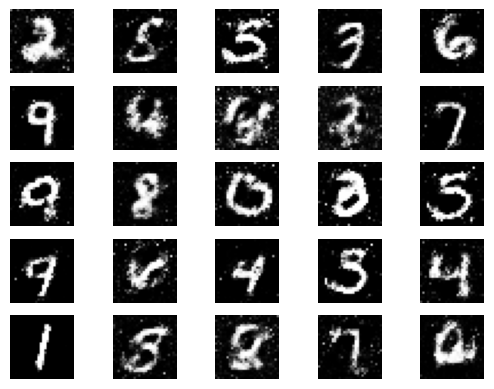

2/2 [==============================] - 0s 7ms/step
5601 [D loss: 0.659819, acc.: 56.25%] [G loss: 0.926286]
2/2 [==============================] - 0s 6ms/step
5602 [D loss: 0.660580, acc.: 64.06%] [G loss: 0.855708]
2/2 [==============================] - 0s 4ms/step
5603 [D loss: 0.649922, acc.: 59.38%] [G loss: 0.896975]
2/2 [==============================] - 0s 4ms/step
5604 [D loss: 0.669799, acc.: 59.38%] [G loss: 0.869406]
2/2 [==============================] - 0s 7ms/step
5605 [D loss: 0.662713, acc.: 62.50%] [G loss: 0.888236]
2/2 [==============================] - 0s 4ms/step
5606 [D loss: 0.633988, acc.: 65.62%] [G loss: 0.859366]
2/2 [==============================] - 0s 7ms/step
5607 [D loss: 0.678609, acc.: 60.16%] [G loss: 0.893443]
2/2 [==============================] - 0s 6ms/step
5608 [D loss: 0.633419, acc.: 64.06%] [G loss: 0.890871]
2/2 [==============================] - 0s 5ms/step
5609 [D loss: 0.647822, acc.: 64.06%] [G loss: 0.980876]
2/2 [=======================

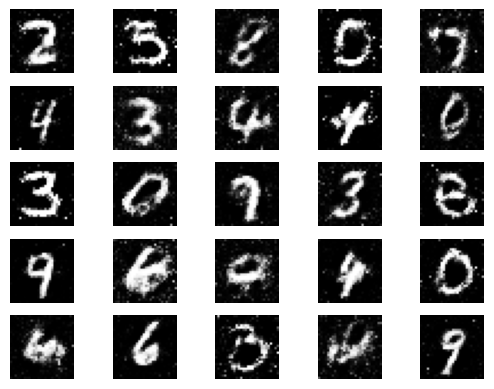

2/2 [==============================] - 0s 8ms/step
5801 [D loss: 0.655914, acc.: 58.59%] [G loss: 0.874603]
2/2 [==============================] - 0s 4ms/step
5802 [D loss: 0.641709, acc.: 63.28%] [G loss: 0.950574]
2/2 [==============================] - 0s 4ms/step
5803 [D loss: 0.652563, acc.: 65.62%] [G loss: 0.915450]
2/2 [==============================] - 0s 5ms/step
5804 [D loss: 0.654825, acc.: 61.72%] [G loss: 0.925897]
2/2 [==============================] - 0s 4ms/step
5805 [D loss: 0.644181, acc.: 64.06%] [G loss: 0.932447]
2/2 [==============================] - 0s 6ms/step
5806 [D loss: 0.632385, acc.: 66.41%] [G loss: 0.865533]
2/2 [==============================] - 0s 8ms/step
5807 [D loss: 0.684261, acc.: 53.12%] [G loss: 0.923676]
2/2 [==============================] - 0s 4ms/step
5808 [D loss: 0.669298, acc.: 60.94%] [G loss: 0.903665]
2/2 [==============================] - 0s 6ms/step
5809 [D loss: 0.640374, acc.: 67.97%] [G loss: 0.947734]
2/2 [=======================

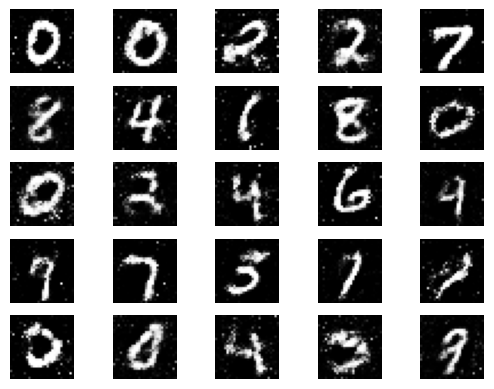

2/2 [==============================] - 0s 5ms/step
6001 [D loss: 0.624863, acc.: 67.19%] [G loss: 0.893096]
2/2 [==============================] - 0s 4ms/step
6002 [D loss: 0.666237, acc.: 56.25%] [G loss: 0.869004]
2/2 [==============================] - 0s 4ms/step
6003 [D loss: 0.627988, acc.: 66.41%] [G loss: 0.900396]
2/2 [==============================] - 0s 7ms/step
6004 [D loss: 0.628144, acc.: 65.62%] [G loss: 0.893924]
2/2 [==============================] - 0s 5ms/step
6005 [D loss: 0.635973, acc.: 64.84%] [G loss: 0.886817]
2/2 [==============================] - 0s 4ms/step
6006 [D loss: 0.648528, acc.: 59.38%] [G loss: 0.891467]
2/2 [==============================] - 0s 4ms/step
6007 [D loss: 0.638174, acc.: 65.62%] [G loss: 0.884236]
2/2 [==============================] - 0s 4ms/step
6008 [D loss: 0.625849, acc.: 64.84%] [G loss: 0.926914]
2/2 [==============================] - 0s 5ms/step
6009 [D loss: 0.646937, acc.: 66.41%] [G loss: 0.900664]
2/2 [=======================

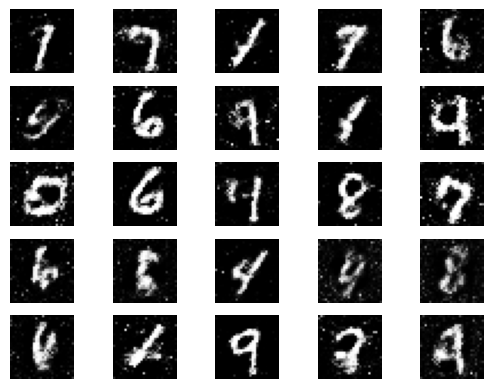

2/2 [==============================] - 0s 5ms/step
6201 [D loss: 0.676657, acc.: 55.47%] [G loss: 0.898205]
2/2 [==============================] - 0s 6ms/step
6202 [D loss: 0.673281, acc.: 60.16%] [G loss: 0.914227]
2/2 [==============================] - 0s 7ms/step
6203 [D loss: 0.648605, acc.: 61.72%] [G loss: 0.870061]
2/2 [==============================] - 0s 4ms/step
6204 [D loss: 0.643837, acc.: 63.28%] [G loss: 0.867660]
2/2 [==============================] - 0s 5ms/step
6205 [D loss: 0.683153, acc.: 53.91%] [G loss: 0.820523]
2/2 [==============================] - 0s 4ms/step
6206 [D loss: 0.664009, acc.: 55.47%] [G loss: 0.887485]
2/2 [==============================] - 0s 4ms/step
6207 [D loss: 0.673981, acc.: 57.81%] [G loss: 0.907818]
2/2 [==============================] - 0s 6ms/step
6208 [D loss: 0.649935, acc.: 61.72%] [G loss: 0.851151]
2/2 [==============================] - 0s 4ms/step
6209 [D loss: 0.608141, acc.: 67.97%] [G loss: 0.893939]
2/2 [=======================

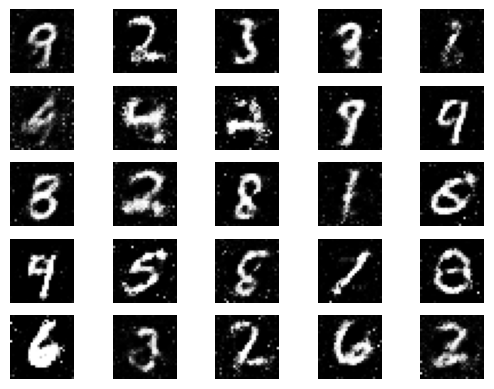

2/2 [==============================] - 0s 5ms/step
6401 [D loss: 0.621301, acc.: 65.62%] [G loss: 0.842788]
2/2 [==============================] - 0s 4ms/step
6402 [D loss: 0.646881, acc.: 64.84%] [G loss: 0.867220]
2/2 [==============================] - 0s 5ms/step
6403 [D loss: 0.653127, acc.: 62.50%] [G loss: 0.933504]
2/2 [==============================] - 0s 4ms/step
6404 [D loss: 0.692949, acc.: 53.91%] [G loss: 0.907413]
2/2 [==============================] - 0s 4ms/step
6405 [D loss: 0.607895, acc.: 67.97%] [G loss: 0.916490]
2/2 [==============================] - 0s 6ms/step
6406 [D loss: 0.678954, acc.: 60.94%] [G loss: 0.862819]
2/2 [==============================] - 0s 8ms/step
6407 [D loss: 0.644002, acc.: 61.72%] [G loss: 0.835741]
2/2 [==============================] - 0s 4ms/step
6408 [D loss: 0.653642, acc.: 56.25%] [G loss: 0.875991]
2/2 [==============================] - 0s 4ms/step
6409 [D loss: 0.636919, acc.: 64.06%] [G loss: 0.897535]
2/2 [=======================

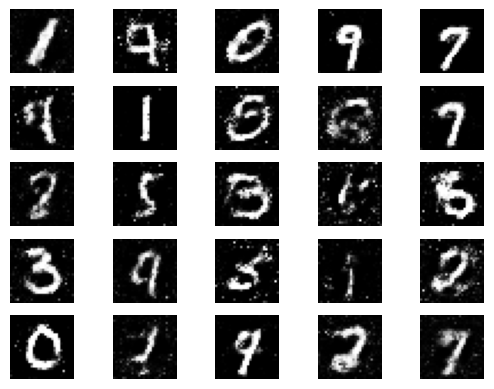

2/2 [==============================] - 0s 5ms/step
6601 [D loss: 0.676525, acc.: 59.38%] [G loss: 0.859182]
2/2 [==============================] - 0s 4ms/step
6602 [D loss: 0.633196, acc.: 67.19%] [G loss: 0.903323]
2/2 [==============================] - 0s 4ms/step
6603 [D loss: 0.696240, acc.: 57.03%] [G loss: 0.861400]
2/2 [==============================] - 0s 9ms/step
6604 [D loss: 0.627183, acc.: 66.41%] [G loss: 0.990099]
2/2 [==============================] - 0s 4ms/step
6605 [D loss: 0.658155, acc.: 58.59%] [G loss: 0.931972]
2/2 [==============================] - 0s 4ms/step
6606 [D loss: 0.661348, acc.: 62.50%] [G loss: 0.956454]
2/2 [==============================] - 0s 4ms/step
6607 [D loss: 0.676183, acc.: 54.69%] [G loss: 0.863627]
2/2 [==============================] - 0s 4ms/step
6608 [D loss: 0.624997, acc.: 60.94%] [G loss: 0.889047]
2/2 [==============================] - 0s 8ms/step
6609 [D loss: 0.673862, acc.: 62.50%] [G loss: 0.860618]
2/2 [=======================

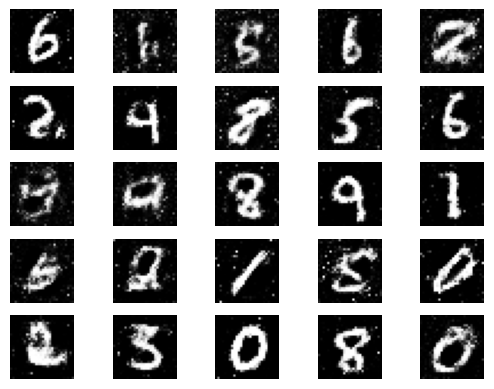

2/2 [==============================] - 0s 7ms/step
6801 [D loss: 0.670452, acc.: 54.69%] [G loss: 0.923552]
2/2 [==============================] - 0s 4ms/step
6802 [D loss: 0.657187, acc.: 61.72%] [G loss: 0.894074]
2/2 [==============================] - 0s 4ms/step
6803 [D loss: 0.657256, acc.: 60.94%] [G loss: 0.889149]
2/2 [==============================] - 0s 4ms/step
6804 [D loss: 0.673226, acc.: 57.81%] [G loss: 0.884448]
2/2 [==============================] - 0s 8ms/step
6805 [D loss: 0.653140, acc.: 65.62%] [G loss: 0.868993]
2/2 [==============================] - 0s 7ms/step
6806 [D loss: 0.658522, acc.: 60.94%] [G loss: 0.835169]
2/2 [==============================] - 0s 7ms/step
6807 [D loss: 0.638399, acc.: 64.06%] [G loss: 0.852593]
2/2 [==============================] - 0s 4ms/step
6808 [D loss: 0.701439, acc.: 53.12%] [G loss: 0.947470]
2/2 [==============================] - 0s 3ms/step
6809 [D loss: 0.667162, acc.: 61.72%] [G loss: 0.900622]
2/2 [=======================

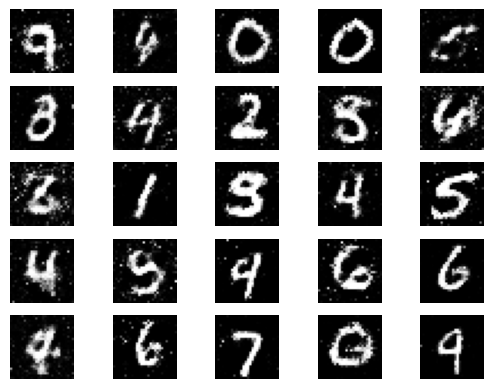

2/2 [==============================] - 0s 9ms/step
7001 [D loss: 0.615832, acc.: 66.41%] [G loss: 0.920093]
2/2 [==============================] - 0s 7ms/step
7002 [D loss: 0.686614, acc.: 53.12%] [G loss: 0.920936]
2/2 [==============================] - 0s 9ms/step
7003 [D loss: 0.683895, acc.: 53.12%] [G loss: 0.929499]
2/2 [==============================] - 0s 8ms/step
7004 [D loss: 0.666714, acc.: 55.47%] [G loss: 0.944230]
2/2 [==============================] - 0s 6ms/step
7005 [D loss: 0.657376, acc.: 62.50%] [G loss: 0.862557]
2/2 [==============================] - 0s 4ms/step
7006 [D loss: 0.668186, acc.: 61.72%] [G loss: 0.911875]
2/2 [==============================] - 0s 5ms/step
7007 [D loss: 0.637384, acc.: 64.06%] [G loss: 0.918546]
2/2 [==============================] - 0s 8ms/step
7008 [D loss: 0.610603, acc.: 70.31%] [G loss: 0.909148]
2/2 [==============================] - 0s 4ms/step
7009 [D loss: 0.652733, acc.: 62.50%] [G loss: 0.879498]
2/2 [=======================

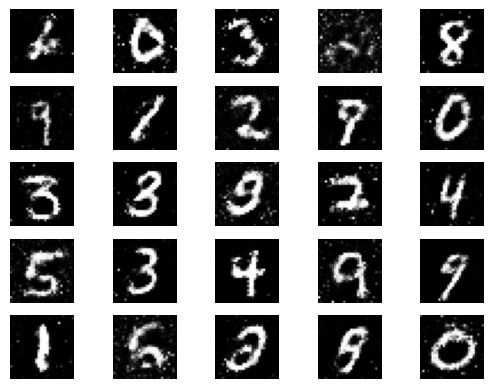

2/2 [==============================] - 0s 4ms/step
7201 [D loss: 0.665060, acc.: 54.69%] [G loss: 0.884162]
2/2 [==============================] - 0s 4ms/step
7202 [D loss: 0.647393, acc.: 64.06%] [G loss: 0.849453]
2/2 [==============================] - 0s 4ms/step
7203 [D loss: 0.670914, acc.: 57.03%] [G loss: 0.883769]
2/2 [==============================] - 0s 4ms/step
7204 [D loss: 0.688550, acc.: 51.56%] [G loss: 0.900615]
2/2 [==============================] - 0s 4ms/step
7205 [D loss: 0.617821, acc.: 67.19%] [G loss: 0.833854]
2/2 [==============================] - 0s 5ms/step
7206 [D loss: 0.719155, acc.: 54.69%] [G loss: 0.867782]
2/2 [==============================] - 0s 4ms/step
7207 [D loss: 0.689642, acc.: 55.47%] [G loss: 0.895033]
2/2 [==============================] - 0s 4ms/step
7208 [D loss: 0.670910, acc.: 62.50%] [G loss: 0.836485]
2/2 [==============================] - 0s 4ms/step
7209 [D loss: 0.659347, acc.: 59.38%] [G loss: 0.869753]
2/2 [=======================

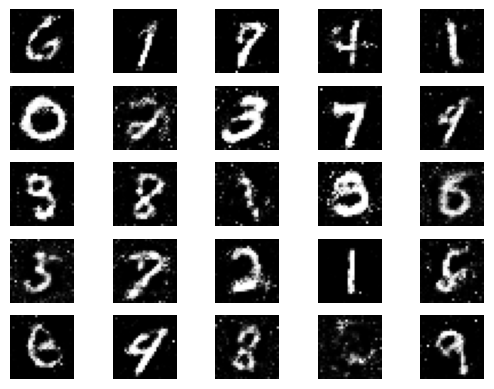

2/2 [==============================] - 0s 4ms/step
7401 [D loss: 0.681923, acc.: 55.47%] [G loss: 0.920122]
2/2 [==============================] - 0s 4ms/step
7402 [D loss: 0.691338, acc.: 60.16%] [G loss: 0.870529]
2/2 [==============================] - 0s 5ms/step
7403 [D loss: 0.662164, acc.: 60.94%] [G loss: 0.902463]
2/2 [==============================] - 0s 4ms/step
7404 [D loss: 0.659850, acc.: 60.94%] [G loss: 0.876467]
2/2 [==============================] - 0s 4ms/step
7405 [D loss: 0.662219, acc.: 60.94%] [G loss: 0.813620]
2/2 [==============================] - 0s 7ms/step
7406 [D loss: 0.628361, acc.: 64.84%] [G loss: 0.859178]
2/2 [==============================] - 0s 4ms/step
7407 [D loss: 0.621783, acc.: 66.41%] [G loss: 0.879817]
2/2 [==============================] - 0s 5ms/step
7408 [D loss: 0.690670, acc.: 58.59%] [G loss: 0.900803]
2/2 [==============================] - 0s 4ms/step
7409 [D loss: 0.666096, acc.: 54.69%] [G loss: 0.892206]
2/2 [=======================

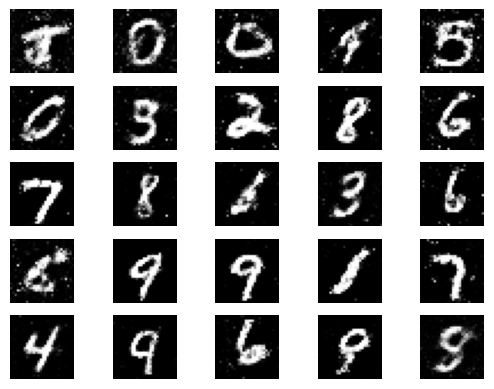

2/2 [==============================] - 0s 7ms/step
7601 [D loss: 0.660590, acc.: 58.59%] [G loss: 0.834427]
2/2 [==============================] - 0s 6ms/step
7602 [D loss: 0.650949, acc.: 64.06%] [G loss: 0.811932]
2/2 [==============================] - 0s 7ms/step
7603 [D loss: 0.675009, acc.: 62.50%] [G loss: 0.841290]
2/2 [==============================] - 0s 5ms/step
7604 [D loss: 0.659806, acc.: 60.94%] [G loss: 0.883238]
2/2 [==============================] - 0s 4ms/step
7605 [D loss: 0.619029, acc.: 67.97%] [G loss: 0.866796]
2/2 [==============================] - 0s 4ms/step
7606 [D loss: 0.646625, acc.: 61.72%] [G loss: 0.887447]
2/2 [==============================] - 0s 5ms/step
7607 [D loss: 0.599959, acc.: 66.41%] [G loss: 0.869300]
2/2 [==============================] - 0s 7ms/step
7608 [D loss: 0.701742, acc.: 46.09%] [G loss: 0.899457]
2/2 [==============================] - 0s 7ms/step
7609 [D loss: 0.676777, acc.: 57.81%] [G loss: 0.855268]
2/2 [=======================

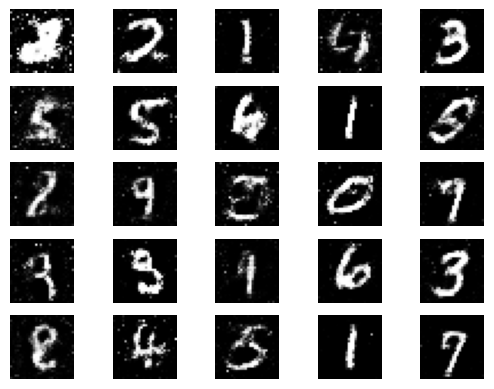

2/2 [==============================] - 0s 4ms/step
7801 [D loss: 0.655345, acc.: 63.28%] [G loss: 0.918617]
2/2 [==============================] - 0s 8ms/step
7802 [D loss: 0.677433, acc.: 56.25%] [G loss: 0.801001]
2/2 [==============================] - 0s 8ms/step
7803 [D loss: 0.635571, acc.: 63.28%] [G loss: 0.822450]
2/2 [==============================] - 0s 4ms/step
7804 [D loss: 0.732071, acc.: 51.56%] [G loss: 0.838846]
2/2 [==============================] - 0s 9ms/step
7805 [D loss: 0.647560, acc.: 58.59%] [G loss: 0.946511]
2/2 [==============================] - 0s 6ms/step
7806 [D loss: 0.674504, acc.: 58.59%] [G loss: 0.891169]
2/2 [==============================] - 0s 8ms/step
7807 [D loss: 0.640247, acc.: 66.41%] [G loss: 0.891343]
2/2 [==============================] - 0s 6ms/step
7808 [D loss: 0.649252, acc.: 59.38%] [G loss: 0.891681]
2/2 [==============================] - 0s 8ms/step
7809 [D loss: 0.601755, acc.: 73.44%] [G loss: 0.872131]
2/2 [=======================

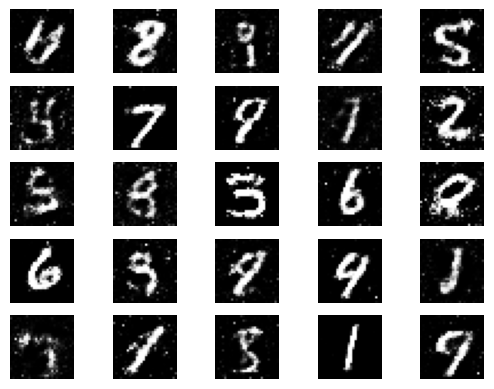

2/2 [==============================] - 0s 7ms/step
8001 [D loss: 0.642863, acc.: 65.62%] [G loss: 0.907183]
2/2 [==============================] - 0s 7ms/step
8002 [D loss: 0.640956, acc.: 64.06%] [G loss: 0.915853]
2/2 [==============================] - 0s 6ms/step
8003 [D loss: 0.670850, acc.: 56.25%] [G loss: 0.916990]
2/2 [==============================] - 0s 4ms/step
8004 [D loss: 0.624713, acc.: 66.41%] [G loss: 0.986610]
2/2 [==============================] - 0s 4ms/step
8005 [D loss: 0.660972, acc.: 57.03%] [G loss: 0.918325]
2/2 [==============================] - 0s 4ms/step
8006 [D loss: 0.676498, acc.: 57.03%] [G loss: 0.931376]
2/2 [==============================] - 0s 4ms/step
8007 [D loss: 0.669976, acc.: 58.59%] [G loss: 0.914242]
2/2 [==============================] - 0s 6ms/step
8008 [D loss: 0.677671, acc.: 55.47%] [G loss: 0.898848]
2/2 [==============================] - 0s 4ms/step
8009 [D loss: 0.685233, acc.: 55.47%] [G loss: 0.850712]
2/2 [=======================

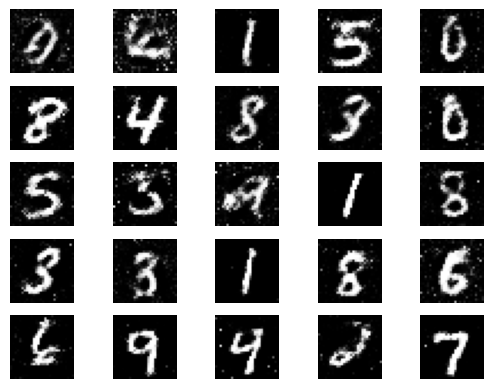

2/2 [==============================] - 0s 4ms/step
8201 [D loss: 0.690328, acc.: 57.81%] [G loss: 0.907717]
2/2 [==============================] - 0s 6ms/step
8202 [D loss: 0.646734, acc.: 63.28%] [G loss: 0.914916]
2/2 [==============================] - 0s 4ms/step
8203 [D loss: 0.648561, acc.: 66.41%] [G loss: 0.903783]
2/2 [==============================] - 0s 4ms/step
8204 [D loss: 0.619004, acc.: 64.06%] [G loss: 0.892170]
2/2 [==============================] - 0s 4ms/step
8205 [D loss: 0.647235, acc.: 63.28%] [G loss: 0.927809]
2/2 [==============================] - 0s 7ms/step
8206 [D loss: 0.643305, acc.: 68.75%] [G loss: 0.880325]
2/2 [==============================] - 0s 4ms/step
8207 [D loss: 0.627672, acc.: 63.28%] [G loss: 0.904469]
2/2 [==============================] - 0s 4ms/step
8208 [D loss: 0.647475, acc.: 62.50%] [G loss: 0.908785]
2/2 [==============================] - 0s 3ms/step
8209 [D loss: 0.644751, acc.: 62.50%] [G loss: 0.830402]
2/2 [=======================

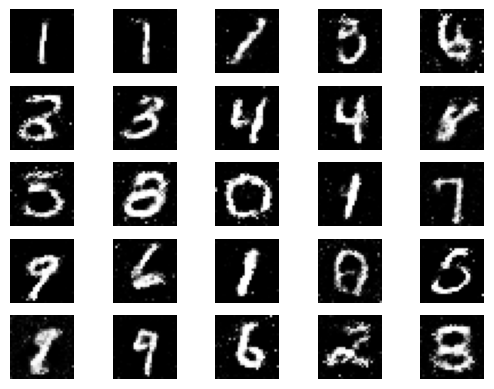

2/2 [==============================] - 0s 4ms/step
8401 [D loss: 0.649071, acc.: 59.38%] [G loss: 0.964489]
2/2 [==============================] - 0s 4ms/step
8402 [D loss: 0.659800, acc.: 63.28%] [G loss: 0.889930]
2/2 [==============================] - 0s 4ms/step
8403 [D loss: 0.636869, acc.: 61.72%] [G loss: 0.918675]
2/2 [==============================] - 0s 5ms/step
8404 [D loss: 0.713436, acc.: 55.47%] [G loss: 0.832923]
2/2 [==============================] - 0s 4ms/step
8405 [D loss: 0.737917, acc.: 46.09%] [G loss: 0.866678]
2/2 [==============================] - 0s 4ms/step
8406 [D loss: 0.697024, acc.: 54.69%] [G loss: 0.854563]
2/2 [==============================] - 0s 4ms/step
8407 [D loss: 0.657915, acc.: 66.41%] [G loss: 0.875808]
2/2 [==============================] - 0s 6ms/step
8408 [D loss: 0.681240, acc.: 60.94%] [G loss: 0.918355]
2/2 [==============================] - 0s 4ms/step
8409 [D loss: 0.636977, acc.: 60.94%] [G loss: 0.936955]
2/2 [=======================

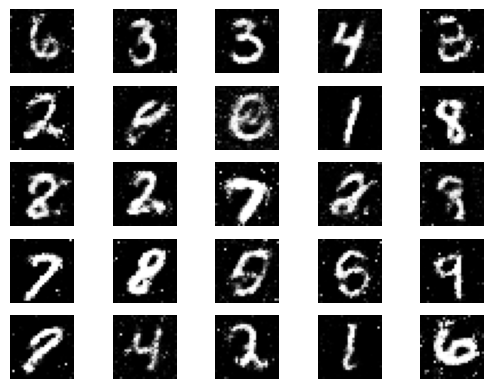

2/2 [==============================] - 0s 5ms/step
8601 [D loss: 0.660032, acc.: 63.28%] [G loss: 0.908602]
2/2 [==============================] - 0s 5ms/step
8602 [D loss: 0.631927, acc.: 66.41%] [G loss: 0.857995]
2/2 [==============================] - 0s 6ms/step
8603 [D loss: 0.646220, acc.: 63.28%] [G loss: 0.868513]
2/2 [==============================] - 0s 5ms/step
8604 [D loss: 0.652251, acc.: 58.59%] [G loss: 0.891873]
2/2 [==============================] - 0s 5ms/step
8605 [D loss: 0.644149, acc.: 66.41%] [G loss: 0.910332]
2/2 [==============================] - 0s 4ms/step
8606 [D loss: 0.684976, acc.: 52.34%] [G loss: 0.883459]
2/2 [==============================] - 0s 9ms/step
8607 [D loss: 0.614141, acc.: 65.62%] [G loss: 0.877740]
2/2 [==============================] - 0s 6ms/step
8608 [D loss: 0.637043, acc.: 61.72%] [G loss: 0.858850]
2/2 [==============================] - 0s 6ms/step
8609 [D loss: 0.647958, acc.: 64.06%] [G loss: 0.895484]
2/2 [=======================

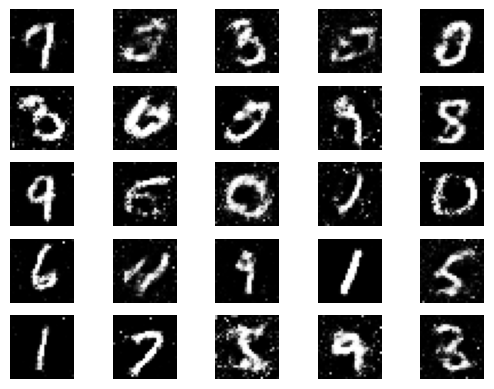

2/2 [==============================] - 0s 5ms/step
8801 [D loss: 0.640486, acc.: 61.72%] [G loss: 0.937304]
2/2 [==============================] - 0s 4ms/step
8802 [D loss: 0.671742, acc.: 56.25%] [G loss: 0.841870]
2/2 [==============================] - 0s 4ms/step
8803 [D loss: 0.695665, acc.: 51.56%] [G loss: 0.866768]
2/2 [==============================] - 0s 5ms/step
8804 [D loss: 0.660218, acc.: 60.94%] [G loss: 0.900088]
2/2 [==============================] - 0s 5ms/step
8805 [D loss: 0.677303, acc.: 54.69%] [G loss: 0.884283]
2/2 [==============================] - 0s 4ms/step
8806 [D loss: 0.659426, acc.: 57.81%] [G loss: 0.866434]
2/2 [==============================] - 0s 4ms/step
8807 [D loss: 0.668713, acc.: 59.38%] [G loss: 0.914979]
2/2 [==============================] - 0s 7ms/step
8808 [D loss: 0.680857, acc.: 57.81%] [G loss: 0.825134]
2/2 [==============================] - 0s 4ms/step
8809 [D loss: 0.663477, acc.: 60.94%] [G loss: 0.882820]
2/2 [=======================

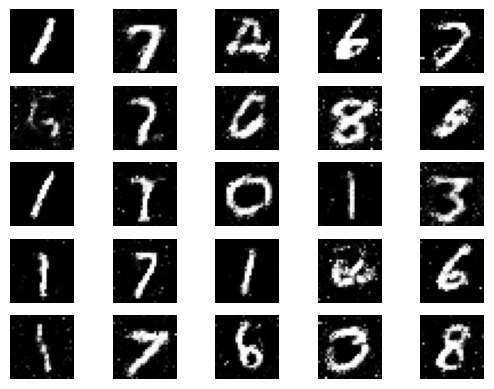

2/2 [==============================] - 0s 8ms/step
9001 [D loss: 0.673453, acc.: 63.28%] [G loss: 0.827852]
2/2 [==============================] - 0s 6ms/step
9002 [D loss: 0.678110, acc.: 57.81%] [G loss: 0.863058]
2/2 [==============================] - 0s 4ms/step
9003 [D loss: 0.651559, acc.: 65.62%] [G loss: 0.865825]
2/2 [==============================] - 0s 4ms/step
9004 [D loss: 0.639436, acc.: 62.50%] [G loss: 0.889008]
2/2 [==============================] - 0s 6ms/step
9005 [D loss: 0.699594, acc.: 54.69%] [G loss: 0.910614]
2/2 [==============================] - 0s 4ms/step
9006 [D loss: 0.692104, acc.: 60.16%] [G loss: 0.845728]
2/2 [==============================] - 0s 4ms/step
9007 [D loss: 0.660771, acc.: 59.38%] [G loss: 0.905006]
2/2 [==============================] - 0s 4ms/step
9008 [D loss: 0.658787, acc.: 63.28%] [G loss: 0.858908]
2/2 [==============================] - 0s 4ms/step
9009 [D loss: 0.614200, acc.: 69.53%] [G loss: 0.873941]
2/2 [=======================

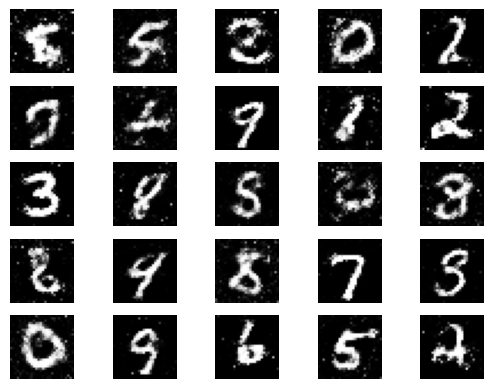

2/2 [==============================] - 0s 6ms/step
9201 [D loss: 0.668913, acc.: 58.59%] [G loss: 0.856945]
2/2 [==============================] - 0s 5ms/step
9202 [D loss: 0.654767, acc.: 62.50%] [G loss: 0.831849]
2/2 [==============================] - 0s 4ms/step
9203 [D loss: 0.619991, acc.: 65.62%] [G loss: 0.883976]
2/2 [==============================] - 0s 4ms/step
9204 [D loss: 0.669984, acc.: 60.94%] [G loss: 0.828888]
2/2 [==============================] - 0s 8ms/step
9205 [D loss: 0.638779, acc.: 64.84%] [G loss: 0.861571]
2/2 [==============================] - 0s 4ms/step
9206 [D loss: 0.622136, acc.: 60.94%] [G loss: 0.811448]
2/2 [==============================] - 0s 4ms/step
9207 [D loss: 0.655497, acc.: 61.72%] [G loss: 0.907622]
2/2 [==============================] - 0s 7ms/step
9208 [D loss: 0.628896, acc.: 60.16%] [G loss: 0.946239]
2/2 [==============================] - 0s 7ms/step
9209 [D loss: 0.674272, acc.: 59.38%] [G loss: 0.934677]
2/2 [=======================

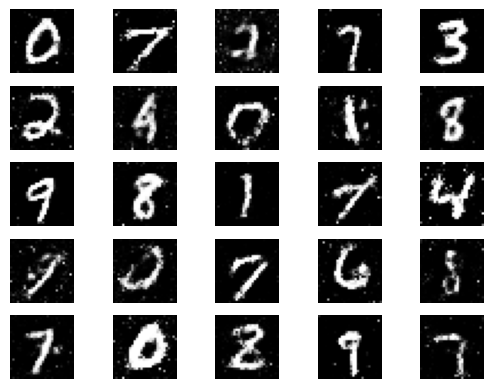

2/2 [==============================] - 0s 4ms/step
9401 [D loss: 0.611700, acc.: 71.09%] [G loss: 0.861074]
2/2 [==============================] - 0s 8ms/step
9402 [D loss: 0.616410, acc.: 64.84%] [G loss: 0.898575]
2/2 [==============================] - 0s 4ms/step
9403 [D loss: 0.672208, acc.: 53.91%] [G loss: 0.827087]
2/2 [==============================] - 0s 4ms/step
9404 [D loss: 0.642515, acc.: 65.62%] [G loss: 0.869848]
2/2 [==============================] - 0s 4ms/step
9405 [D loss: 0.677352, acc.: 61.72%] [G loss: 0.826490]
2/2 [==============================] - 0s 4ms/step
9406 [D loss: 0.629070, acc.: 63.28%] [G loss: 0.912344]
2/2 [==============================] - 0s 4ms/step
9407 [D loss: 0.666983, acc.: 61.72%] [G loss: 0.885728]
2/2 [==============================] - 0s 4ms/step
9408 [D loss: 0.670410, acc.: 64.84%] [G loss: 0.867125]
2/2 [==============================] - 0s 8ms/step
9409 [D loss: 0.697654, acc.: 57.81%] [G loss: 0.880009]
2/2 [=======================

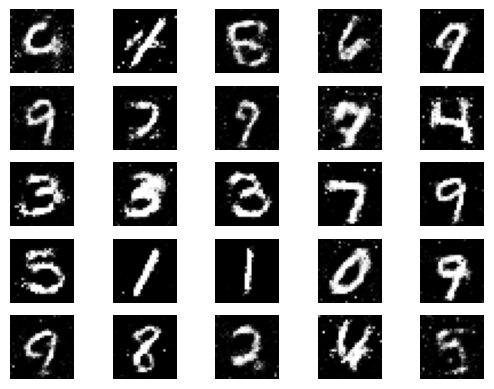

2/2 [==============================] - 0s 4ms/step
9601 [D loss: 0.682543, acc.: 57.81%] [G loss: 0.970618]
2/2 [==============================] - 0s 4ms/step
9602 [D loss: 0.648755, acc.: 64.06%] [G loss: 0.944880]
2/2 [==============================] - 0s 4ms/step
9603 [D loss: 0.688748, acc.: 56.25%] [G loss: 0.921921]
2/2 [==============================] - 0s 4ms/step
9604 [D loss: 0.635342, acc.: 66.41%] [G loss: 0.866314]
2/2 [==============================] - 0s 4ms/step
9605 [D loss: 0.657517, acc.: 60.16%] [G loss: 0.888925]
2/2 [==============================] - 0s 5ms/step
9606 [D loss: 0.618040, acc.: 67.97%] [G loss: 0.896668]
2/2 [==============================] - 0s 4ms/step
9607 [D loss: 0.674310, acc.: 60.94%] [G loss: 0.836714]
2/2 [==============================] - 0s 4ms/step
9608 [D loss: 0.655849, acc.: 60.16%] [G loss: 0.884020]
2/2 [==============================] - 0s 4ms/step
9609 [D loss: 0.662007, acc.: 58.59%] [G loss: 0.885195]
2/2 [=======================

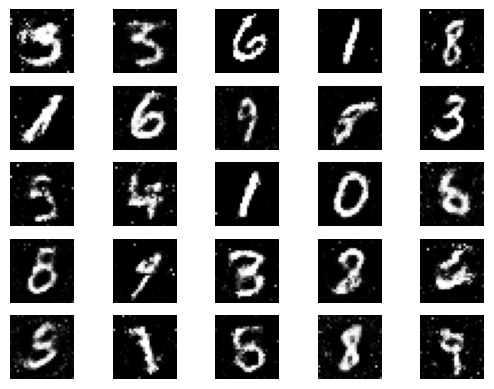

2/2 [==============================] - 0s 4ms/step
9801 [D loss: 0.667178, acc.: 58.59%] [G loss: 0.904556]
2/2 [==============================] - 0s 4ms/step
9802 [D loss: 0.712190, acc.: 52.34%] [G loss: 0.869238]
2/2 [==============================] - 0s 7ms/step
9803 [D loss: 0.655879, acc.: 60.16%] [G loss: 0.838335]
2/2 [==============================] - 0s 7ms/step
9804 [D loss: 0.671313, acc.: 53.12%] [G loss: 0.917520]
2/2 [==============================] - 0s 7ms/step
9805 [D loss: 0.653286, acc.: 54.69%] [G loss: 0.857798]
2/2 [==============================] - 0s 7ms/step
9806 [D loss: 0.670057, acc.: 58.59%] [G loss: 0.817342]
2/2 [==============================] - 0s 4ms/step
9807 [D loss: 0.639864, acc.: 64.84%] [G loss: 0.867897]
2/2 [==============================] - 0s 4ms/step
9808 [D loss: 0.694376, acc.: 57.81%] [G loss: 0.932205]
2/2 [==============================] - 0s 4ms/step
9809 [D loss: 0.695384, acc.: 57.03%] [G loss: 0.861374]
2/2 [=======================

In [3]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10000, batch_size=64, sample_interval=200)